# Introduction

The [HHL algorithm](https://en.wikipedia.org/wiki/Quantum_algorithm_for_linear_systems_of_equations) underlies many quantum machine learning protocols, but it is a highly nontrivial algorithm with lots of conditions. In this notebook, we implement the algorithm to gain a better understanding of how it works and when it works efficiently. The notebook is derived from the [computational appendix](https://gitlab.com/apozas/bayesian-dl-quantum) of the paper [Bayesian Deep Learning on a Quantum Computer](https://arxiv.org/abs/1806.11463). We restrict our attention to inverting a $2\times 2$ matrix, following Pan *et al*.'s implementation [[1](#1)] of the algorithm.

In [1]:
# This cell only for package version control
import sys
import qiskit
import numpy
import matplotlib
print('python    :', sys.version)
print('qiskit    :',qiskit.__version__, qiskit.__qiskit_version__)
print('numpy     :',numpy.__version__)
print('matplotlib:',matplotlib.__version__)

python    : 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]
qiskit    : 0.25.1 {'qiskit-terra': '0.25.1', 'qiskit': '0.44.1', 'qiskit-aer': '0.12.2', 'qiskit-ignis': '0.7.1', 'qiskit-ibmq-provider': None, 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': '0.5.0', 'qiskit-machine-learning': '0.6.1'}
numpy     : 1.26.0
matplotlib: 3.6.0


In [2]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer as Aer
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info.operators import Operator
π = np.pi

In [3]:
# This is a support routine only for trimming what would otherwise be a very long list of states. We use this
# statevector simulation in case of large Hilbert space. It prints only statevector elements with 
# an absolute amplitude greater than 'eps'. That way we can ignore elements created by (approximation) noise,
# and focus on the most significant components of the state vector

def statevector_significant_elements(circuit, n_qubits, eps = 1e-3):

    # eps  = lower threshold for analysis

    backend  = Aer.get_backend('statevector_simulator')
    res = execute(circuit, backend ).result()
    result = res.get_statevector(circuit)
    for i in range(2**n_qubits):
        if np.abs(result[i])>eps:
            n=format(i,"b")
            print("0"*(n_qubits-len(n))+n, np.round(result[i],3))


# Introduction
## A classical approach to solving the linear equations

We will start with an approach for solving the set of linear equations $Ax=b$ in the classical domain, and then make the transition to the quantum version.
Let $\{\nu_r\}$ be the eigenvectors of the matrix $A$ such:

$$A\nu_r = \lambda_r\nu_r,  r \in\{1,2,\dots, R\}$$
For non-singular $A$, i.e. none of the $\nu_r=0$, we can write for the inverse $A^{-1}$:
$$A^{-1}\nu_r = 1/\lambda_r\nu_r,  r \in\{1,2,\dots, R\}$$ 

We can decompose any vector $z$ into $A$'s eigenvectors

$$z = \sum_{r=1}^R\left(\nu_r^T,z\right)\nu_r \tag{1}$$

Applying $A$ to $z$ yields:
\begin{align}
Az &= \sum_{r=1}^R\left(\nu_r^T,z\right)A\nu_r \\ &= \sum_{r=1}^R\lambda_r\left(\nu_r^T,x\right)\nu_r \tag{2}
\end{align}
Likewise: 
\begin{align}
A^{-1}z &= \sum_{r=1}^R\left(\nu_r^T,z\right)A^{-1}\nu_r \\ &= \sum_{r=1}^R1/\lambda_r\left(\nu_r^T,z\right)\nu_r\tag{3}
\end{align}
So in order to solve for $x$ in $Ax=b$ we substitute:
\begin{align}
x&= A^{-1}b \\
 &= \sum_{r=1}^R1/\lambda_r\left(\nu_r^T,b\right)\nu_r \tag{4}
\end{align}

The quantum matrix inversion is based on the above expression. It finds the eigenvalues $\lambda_r$ and creates a representation of the term $\left(\nu_r^T,b\right)\nu_r$, for which we do not need an explicit expression. If we manage to get hold of the $\lambda_r's$ and convert these into $1/\lambda_r$, then we can immediately compute eq. 4

In order to make the transition to the quantum algorithm we need one more identity.

When $A\nu_r = \lambda_r\nu_r $ then it is easily shown by Taylor expansion of the matrix exponent that:
 $$e^A\nu_r = e^{\lambda_r}\nu_r   $$

Hence, eqn (2) can be rewritten as:  

\begin{align}
e^{A}z &= \sum_{r=1}^R\left(\nu_r^T,x\right)e^{A}\nu_r\\
&= \sum_{r=1}^Re^{\lambda_r}\left(\nu_r^T,x\right)\nu_r \tag{5}
\end{align}
And more specifically
\begin{align}
e^{2\pi iA}z &= \sum_{r=1}^R\left(\nu_r^T,x\right)e^{2\pi iA}\nu_r\\
&= \sum_{r=1}^Re^{2\pi i\lambda_r}\left(\nu_r^T,x\right)\nu_r 
\tag{6}
\end{align}


If A is Hermitian then $e^{2\pi iA}$ is a Unitary matrix, U, and we can write
$$  Uz = \sum_{r=1}^Re^{2\pi i\lambda_r}\left(\nu_r^T,x\right)\nu_r   \tag{7} $$

If $A$ is not Hermitian, then by a simple transformation we can create $A' = \begin{pmatrix} 
0 & {A^{\dagger}}\\
A & 0
\end{pmatrix}    $, which is Hermitian, and solve:

$$\begin{pmatrix} 
0 & {A^{\dagger}}\\
A & 0
\end{pmatrix} 
\begin{pmatrix} 
x  \\
0 
\end{pmatrix}=
\begin{pmatrix} 
0  \\
b 
\end{pmatrix}, $$

## Quantum matrix inversion in 6 steps

We'll introduce the algorithm here in 6 short steps, that will be expanded and interspersed with the code that implements the algorithm

### Step 1 Compute the eigenvalues using the QPE primitive

We know from the previous chapter on quantum phase estimation that if we have an operator U working on one of its eigenvectors $|u\rangle$ where:

$$
U|u\rangle = e^{2\pi i \theta}|u\rangle
$$

then we can find $\theta$ with QPE in base vector encoding in an ancillary register as $|\theta\rangle$. Let's write this as a QPE primitive, $\hat P$, for this specific $U$  that works on 'empty' ancillaregister :

$$\hat P |00\dots00\rangle|u\rangle =|\theta\rangle|u\rangle  $$

Starting from the linear equations to solve $Ax=b$. If we choose $U$ to be equal to $e^{2\pi iA}$, then if $|u\rangle$ is an eigenvector of $A$ with eigenvalue $\lambda$, $|u\rangle$ is also an eigenvector of U. Additionally then, the phase angle $\theta$ is equal to $\lambda$.
Using a shorthand $|k\rangle$ for the ancillary register $|00\dots00\rangle$, we can thus write:

$$ \hat P|k\rangle|u\rangle = |\lambda\rangle|u\rangle     $$

Writing $|b\rangle$ as a decomposition in the eigenvectors $|u_i\rangle$ of $U$

$$\hat{P}|k\rangle|b\rangle \to \sum_i c_i |u_i\rangle|\tilde{\lambda}_i\rangle \text{ ,   } c_i = \langle u_i|b\rangle    $$

In practice we will need to scale the problem with a factor T to avoid practical issues like the eigenvalues becoming larger than $2\pi$ causing wrap around on the unit circle and ambiguity in the solution. Effectively this means that we will work with:

$$ U=e^{2\pi iA/T}   $$

And correct for T at the end by classically dividing it out.

### Step 2 compute the reciprocate eigenvalues

This step is often treated as trivial, but a good implementation will need to deal with this. Ultimately it requires a remapping of the eigenvalue register, as in 

$ \sum_i c_i|u_i\rangle|\lambda_i\rangle \to \sum_ic_i|u_i\rangle|1/\lambda_i\rangle  $.

### Step 3 Extract the eigenvalues
The eigenvalues, or in fact the reciprocate eigenvalues, are still in basis encoding, whereas we need the eigenvalues in amplitude encoding. This requires the application of a controlled rotation step:

$ \sum_ic_i|u_i\rangle|1/\lambda_i\rangle|a\rangle \to  \sum_ic_i|u_i\rangle|1/\lambda_i\rangle\left(e_0|0\rangle + e_1/\lambda_i|1\rangle\right) $

For now we write for the single bit ancillary register: 

$$|a'\rangle =  \xi(\lambda_i)|0\rangle + C/\lambda_i|1\rangle    $$

where $C$ is a real constant,and $\xi(\lambda_i)$ is a function of the eigenvalues. As we will see $\xi(\lambda_i)$ will be removed through 'rejection sampling' at the end, and can be ignored.

### Step 4 Uncompute the reciprocate eigenvalues

Undo the mapping of the eigenvalue register from $|1/\lambda_i\rangle$ to $|\lambda_i\rangle$

$$ \sum_ic_i|u_i\rangle|1/\lambda_i\rangle|a'\rangle   \to \sum_ic_i|u_i\rangle|\lambda_i\rangle|a'\rangle$$

### Step 5 Uncompute the QPE operation using the inverse QPE primitive

As 

$$
\hat P|b\rangle|k\rangle =  \sum_i |u_i\rangle\langle u_i|b\rangle|\lambda_i\rangle   $$
Then:
\begin{align}
\hat P|x\rangle|k\rangle &=  \sum_i |u_i\rangle\langle u_i|\left(\sum_{i'}1/\lambda_{i'} |u_{i'}\rangle \langle u_{i'}|b\rangle\right)|\lambda_i\rangle\\
 &= \sum_i\sum_{i'}1/\lambda_{i'}\langle u_i|u_{i'}\rangle\langle u_i|b\rangle|u_i\rangle|\lambda_i\rangle \\ 
&= \sum_i1/\lambda_i \langle u_i|b\rangle|u_i\rangle|\lambda_i\rangle   
\end{align}


Hence

\begin{align}
\hat P^{-1} \sum_i\langle u_i|b\rangle|u_i\rangle|\lambda_i\rangle|a'\rangle 
&= \sum_i\langle u_i|b\rangle|u_i\rangle|k\rangle(\xi(\lambda_i)|0\rangle + C/\lambda_i|1\rangle)\\ 
&=\sum_i\langle u_i|b\rangle|u_i\rangle|k\rangle \xi(\lambda_i)|0> +\sum_i\langle u_i|b\rangle|u_i\rangle|k\rangle C/\lambda_i|1\rangle\\
\end{align}

As 
$$
\sum_i1/\lambda_i\langle u_i|b\rangle|u_i\rangle = |x\rangle
$$

We can simplify the right hand term and write

$$
\hat P^{-1} \sum_i\langle u_i|b\rangle|u_i\rangle|\lambda_i\rangle|a'\rangle = \sum_i\langle u_i|b\rangle|u_i\rangle|k\rangle \xi(\lambda_i)|0> +C|x\rangle|k\rangle|1\rangle
$$

We see that the right hand term is the answer that we are looking for, scaled with the known constant C. Note that the uncompute steps will return the ancillary register $|k\rangle$ back to its initial state $|00\dots00\rangle$ and puts the solution vector $|x\rangle$ in the input register replacing $|b\rangle$ and using the same amplitude encoding.


### Step 6 Post select on the ancilla value

In the last step we perform a measurement of the ancila qubit and select only those outcomes where the ancilla $|a'\rangle=1$. That leaves us with the correct values for $|x\rangle$, only to be corrected for $C$ and other scaling factors that have been applied in the implementation.

The overall schematics looks like this

<div>
<img src="../figures/QMI-schematics.png" width="600"/>
</div>

# Setting up the problem

We will first solve the equation $Ax=b$ with $A = \frac{1}{2}\begin{bmatrix}3 & 1 \\1 & 3 \\ \end{bmatrix}$ and $b =\begin{bmatrix} 1 \\ 0 \\ \end{bmatrix}$, as in ref[1]. $
The eigenvectors for A are: $ \begin{bmatrix} 1\\1 \end{bmatrix}$ and $ \begin{bmatrix}1\\-1 \end{bmatrix}$. The solution vector is $x = \begin{bmatrix} 3/4\\-1/4 \end{bmatrix}$

with eigenvalues $\lambda_1 = 2$ and $\lambda_2=1$ respectively. Hence, this is a trivial case, as the eigenvalues are powers of 2 that we can represent with a a 2-qubit ancilla register. 

We will also need the unitary $U = e^{2 \pi i A/T}$. Pan et al. had chosen $T=4$. If we ignore the physics behind this step, then this  is basically just a scaling to prevent wrap around of the eigenvalues across the unit circle, which would make the phase angle ambiguous. We will need to correct for this scale factor $T$ at the end of the algorithm.

$$U = \begin{pmatrix} -0.5+0.5i &-0.5-0.5i\\-0.5-0.5i & -0.5+0.5i       \end{pmatrix}    $$

When used as a controlled $U_c$, taking into account the order of the qubits as used in the code, this becomes

$$U_c = \begin{pmatrix}
1& 0 &0 &0\\
0 &-0.5+0.5i  &0 &-0.5-0.5i \\
0 &0 &1&0\\
0 &-0.5-0.5i&0 & -0.5+0.5i       \end{pmatrix}    $$
as $ \mathbf{1} |0\rangle\langle 0| + U |1\rangle\langle 1|$\
As we will use a 2-qubit register for the eigenvalues we will also need $U^2$

$$U^2 = \begin{pmatrix} 0 & 1\\ 1 & 0       \end{pmatrix}    $$
This is a simple not-gate, so $U_c$ can be implemented as a controlled-not gate

So the phase angles that will be found with QPE will be :
$
\begin{align} e^{2\pi i \lambda_1/T} &\to \theta_1 = \lambda_1/T =1/4\\  e^{2\pi i \lambda_2/T} &\to \theta_2 = \lambda_2/T=1/2        \end{align}
$
It is clear that this case allow for some simplifications in the implementation of the algorithm. Nevertheless it will highlight the key steps and the structure of the algorithm.

# Step 1 Quantum phase estimation

The vector $b$ can be encoded as $\left|b\right\rangle = \sum_{i=0}^N b_i\left|i\right\rangle = \left|0\right\rangle$, so no explicit state preparation circuit is needed for this case (this will not be true in general).
We'll apply quantum phase estimation to extract the eigenvalues of the matrix $A$ and encode them in an additional register. As in the section on QPE  we will need an additional register $|k\rangle$ that will hold the eigenvalues, and will be initiated in in uniform superposition.

$$\left|k\right\rangle=\sum_{\tau=0}^{T-1}\left|\tau\right\rangle$$

The original HHL algorithm suggests a weighted superposition of all states $\tau$ that minimizes errors in following steps in the algorithm. This is not unlike the weighting applied for classical discrete Fourier transforms and serves to sharpen the frequency/eigenvalue spectrum. However, for our implementation, which uses powers of 2 for the eigenvalues, a uniform superposition works fine.

The first step is to apply the conditional Hamiltonian evolution, which we have seen in the QPE chapter:

$$\sum_{\tau=0}^{T-1}\left|\tau\right\rangle\left\langle\tau\right|^C\otimes e^{i A\tau 2\pi/T}\text{on } \left|k\right\rangle^C\otimes\left|b\right\rangle$$

Then, as before, we apply an inverse Fourier transformation that writes the eigenvalues, effectively as phase angles, of $A$ into $|k\rangle$, which completed the first step of the quantum matrix inversion.

In our $2\times 2$ case, the circuit is massively simplified. Given that the matrix $A$ has eigenvalues that are powers of $2$, we can choose $T=4$, to obtain exact results with just two controlled evolutions.

In [14]:
# initiate the quantum machine
# q[0]      = |a>, the ancilla
# q[1],q[2] = |k>, holds the λ's and 1/λ's as intermediate states
# q[3]      = |b>, holds the b-vector and the x-vector solution
q = QuantumRegister(4)
c = ClassicalRegister(2)
hhl = QuantumCircuit(q, c)

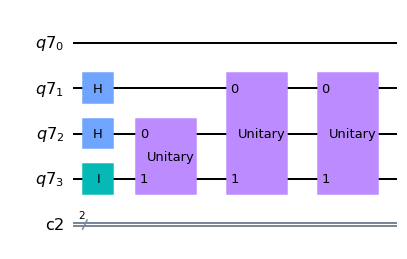

In [15]:
# load b vector in |b> state. As |b>=|0>, the identity operation (read: no operation) is sufficient
hhl.i(q[3])

# start step 1 QPE

# put the qubits of |psi> in uniform superposition
hhl.h(q[1])
hhl.h(q[2])

# Define the unitaries required for the Hamiltonion evolution of the QPE process 
# See the text above for the definition of the controlled U1 operator
D = Operator([[1,0,0,0],[0,-0.5+0.5j,0,-0.5-0.5j],[0,0,1, 0],[0,-0.5 - 0.5j,0, -0.5 + 0.5j]]) 
hhl.append(D,[q[2],q[3]])

# The controlled-U2 operator is a simple cx gate
# As 
# hhl.cx(q[1], q[3])
hhl.append(D,[q[1],q[3]])
hhl.append(D,[q[1],q[3]])
hhl.draw('mpl')

We apply quantum inverse Fourier transformation to write the phase angles, or scaled eigenvalues, to a register:

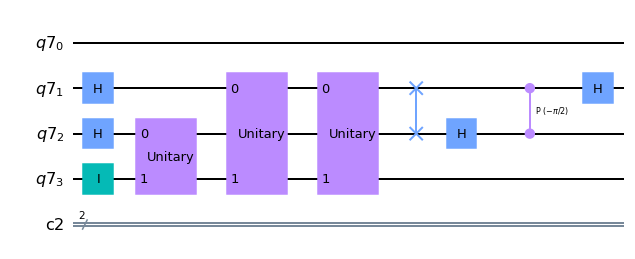

In [16]:
hhl.swap(q[1], q[2])
hhl.h(q[2])
hhl.cp(-π / 2, q[1], q[2])
hhl.h(q[1])

hhl.draw('mpl')

It is useful to inspect the eigenvalue register to understand the result

The state of the system after this decomposition is approximately $\sum _{j{\mathop {=}}1}^{N}c_{j}\left|u_{j}\right\rangle \left|\lambda_{j}\right\rangle$, where $\left|b\right\rangle=\sum _{j{\mathop {=}}1}^{N}c_{j}\left|u_{j}\right\rangle$ is the encoding of the vector $b$ in the eigenbasis of $A$. 
We know $|b\rangle = |u_1\rangle+|u_2\rangle   $, and $|u_1 \rangle = 0.5(|0\rangle+|1\rangle) $, $|u_2 \rangle = 0.5(|0\rangle-|1\rangle) $
As $|\lambda_1\rangle = |01\rangle$, and $|\lambda_2\rangle=|10\rangle$, we expect to see:

\begin{align}
|u_1\rangle|\lambda_1\rangle + |u_2\rangle|\lambda_2\rangle &= 0.5( |0\rangle+|1\rangle)|01\rangle+(|0\rangle-|1\rangle)|10\rangle \\  &= 0.5|001\rangle + 0.5|101\rangle + 0.5|010\rangle - 0.5|110\rangle \end{align}

And that is indeed what we find when we run the wavefunction simulator.

In [17]:
print('q3- b-vector,q2q1- eigenvalues, q0- ancilla' )
print('blla')
statevector_significant_elements(hhl,4)

q3- b-vector,q2q1- eigenvalues, q0- ancilla
blla
0010 (0.5-0j)
0100 (0.5-0j)
1010 (0.5-0j)
1100 (-0.5+0j)


# Step 2 Compute the reciprocal eigenvalues


Now, there is an often overlooked step that maps the amplitude of $\left|\lambda_{j}\right\rangle$ onto $|1/\lambda_i\rangle$ This step has two caveats, in general this will be an approximation depending on the number of qbits available for the eigenvalue register, although this would obviously also be true for a classical machine. Secondly as have scaled the $\lambda's$ to be smaller than 1, we need a similar trick for the $1/\lambda's$.

Thapliyal et al [[2](#2)] have proposed a method based on long division, using a bunch of ancillary qubits for the mapping. Cao et al [[3](#3)] use a Newton-Raphson approximation to similar effect. A nice overview is of these methods is presented in Ubbens [[4](#4)]. 


In our case, the mapping of the eigenvalues is easy, as they are powers of 2. The eigenvalues of $A$ are $\lambda_1=2=10_2$ and $\lambda_2=1=01_2$. The reciprocals are $\lambda_1^{-1}=1/2$ and $\lambda_2^{-1}=1$.
If we swap the amplitudes of the $|01\rangle>$ and the $|10>\rangle$ states in the eigenvalue register, we have the mapping we are looking for, as  $2\lambda_1^{-1}=01_2$ and $2\lambda_2^{-1}=10_2$. We have introduced a scaling factor of 2 by doing so. As with the other scaling factors, also this one will need to be corrected for classically at the end of the computation

So, a swap gate is enough to map from $|\lambda_i\rangle$ to $|1/\lambda_i\rangle$ obtain the state $\sum _{j{\mathop {=}}1}^{N}2\beta _{j}\left|u_{j}\right\rangle \left|\lambda _{j}^{-1}\right\rangle$, that encodes the reciprocate eigenvalues.

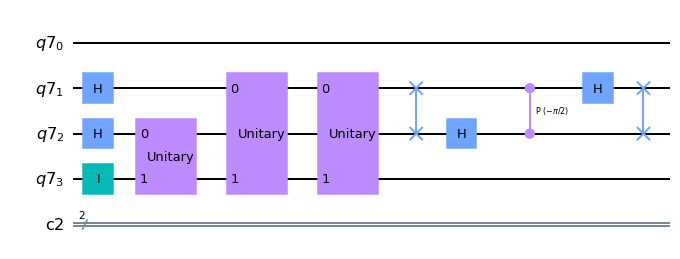

In [18]:
hhl.swap(q[1], q[2])
hhl.draw('mpl')

# Step 3 extract the eigenvalues

In order to get the amplitudes of the reciprocal eigenvalues into the amplitude of the wavefunction we will perform a conditional rotation.

With controlled rotations and adding an ancilla qubit, we are able to make the following transformation:

$\hat{R}|0\rangle|\nu \rangle = \left ( \sqrt{1-\nu ^{2}}|0\rangle+\nu |1\rangle  \right )$

where $0 < \nu <1$

We'll use a series of controlled Ry's to do so

If we expand the $\nu$-register in its individual qbits $|\nu\rangle = |\nu_1\nu_2\dots\nu_R\rangle$ and consider the following number:

$\nu = 0.\nu_1\cdot \nu_2\cdot ...\nu_R = \sum_{j=1}^{R}\nu_j2^{-j}, \nu_j \in \left \{ 0,1 \right \}$

Since $R_y(\alpha)+R_y(\beta) = R_y(\alpha + \beta) $, and $R_y(\alpha)|0\rangle = \cos(\alpha)|0\rangle>+\sin(\alpha)|1\rangle   $, repeated application of a controlled $R^c_y$ over an angle $\frac{\nu_j}{2^j}   $ will yield:

\begin{align}\hat{R}|0\rangle|\nu\rangle &= R^c(\nu_1)R^c(\nu_2/2)\dots R^c(\nu_R/2^R) |0\rangle|\nu_1\nu_2\nu_3\dots\nu_R\rangle\\ &= R_y(0.\nu_1\nu_2\dots\nu_R)|0\rangle|\nu\rangle \\
&=(\cos(\nu)|1\rangle+\sin(\nu)|0\rangle)|\nu\rangle\\
&\approx\left(\sqrt{1-\nu^2}|1\rangle+\nu\right)|0\rangle|\nu\rangle, \text{for small }\nu
\end{align}

We want to apply $\hat{R}$ to the $\sum|0\rangle|1/\lambda_i\rangle$ states, but in order to ensure the rotation angles stay small we will need to introduce another scale factor, such that:
$$\hat{R}|0\rangle|1/\lambda_i\rangle = \left(\sqrt{1-\frac{C^2}{\lambda^2}}|0\rangle +\frac{C}{\lambda}|1\rangle\right)|1/\lambda\rangle  $$

We can apply $\hat{R}$ to:
$\sum_{j=1}^N \beta_j|u_j\rangle|1/\lambda_j\rangle$ to obtain
$$\sum_{j=1}^N  \left(\sqrt{1-\frac{C^2}{\lambda_j^2}}|0\rangle +\frac{C}{\lambda_j}|1\rangle\right)\beta_j|u_j\rangle|1/\lambda_j\rangle  $$
The term between the brackets is essentially just the state of the ancilla qubit, which we can abbreviate as $|a'\rangle$ for now.
So after controlled rotation we are left with 
$$\sum_{j=1}^N  |a'\rangle\beta_j|u_j\rangle|1/\lambda_j\rangle  $$




Pan et al choose $C=\pi/2$, although that is somewhat arbitrary. As with the factor $T$ introduced during the quantum phase estimation step, the scaling of $C$ will be undone clasicically at the end.

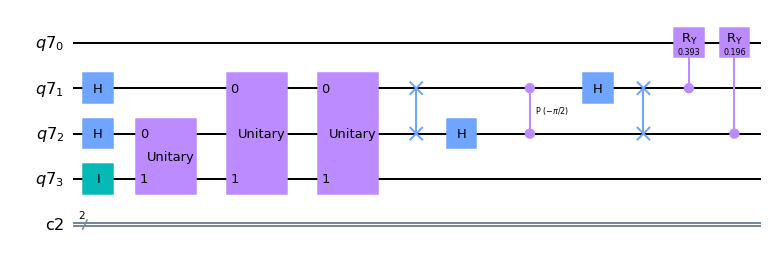

In [19]:
# apply a controlled rotation over pi/8 on the most significant bit of the eigenvalue register 
hhl.cry(0.392699, q[1], q[0])

# apply a controlled rotation over pi/16 on the most significant bit of the eigenvalue register 
hhl.cry(0.19634955, q[2], q[0])

hhl.draw('mpl')

## Step 4 Uncompute the reciprocate eigenvalues

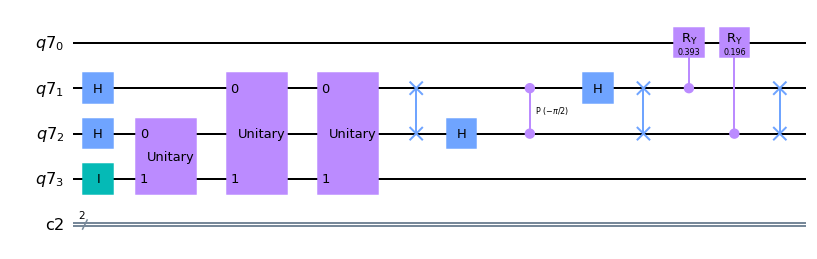

In [20]:
hhl.swap(q[1], q[2])
hhl.draw('mpl')

## Step 5 Uncompute the QPE operation using the inverse QPE primitive

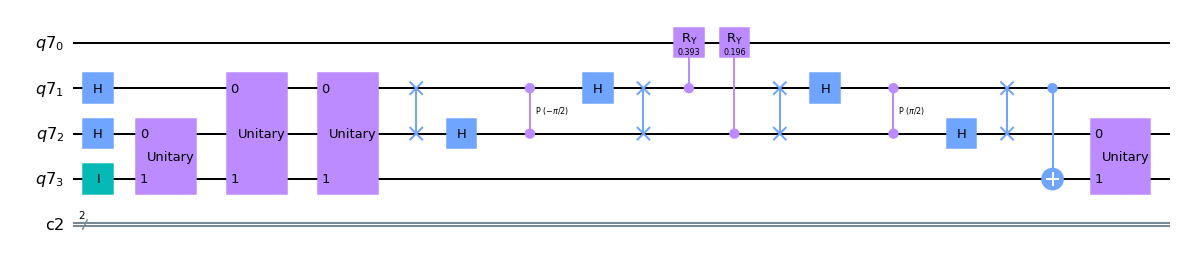

In [21]:
#Apply forward Fourier transform

hhl.h(q[1])
hhl.cp(π / 2, q[1], q[2])
hhl.h(q[2])
hhl.swap(q[2], q[1])

# Apply the inverse Controlled-U2 (actually the gate is its own inverse)
hhl.cx(q[1], q[3])


# Apply the inverse of the controlled-U
#hhl.cx(q[2], q[3])
#hhl.cu1(-3 * π / 4, q[2], q[3])
#hhl.cx(q[2], q[3])
#hhl.cu1(-3 * π / 4, q[2], q[3])
#hhl.cu3(-π / 2, π / 2, -π / 2, q[2], q[3])
D = Operator([[1,0,0,0],[0, -0.5-0.5j,0, -0.5 +0.5j],[0,0,1,0],[0, -0.5 +0.5j, 0, -0.5-0.5j]])
hhl.append(D,[q[2],q[3]])
hhl.draw('mpl')

# Uncomputing the eigenvalue register

A necessary step when performing quantum computations is to uncompute all operations except those that store the information that we want to obtain from the algorithm in the final registers. We need to do this in case the registers are entangled, which would affect the results.


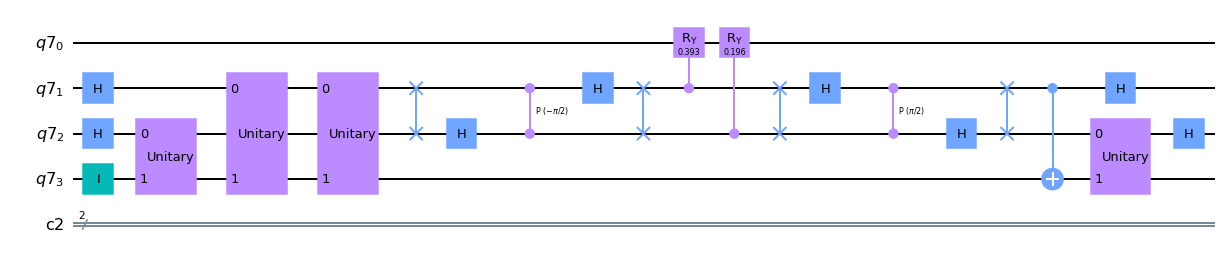

In [22]:
# Bring the eigenvalue register back to its |00> state
hhl.h(q[2])
hhl.h(q[1])
hhl.draw('mpl')

We are now in a state:
$$\sum_{j=1}^N\beta_j|u_j\rangle|0\rangle|a'\rangle     $$
And it is worthwhile to investigate what that looks like before we perform the very last step. The eigenvalue register is in state $|00\rangle$, as intended. We are only interested in those amplitudes for which the ancilla is in state$|1\rangle$. 



In [23]:
print('q3-  |b>\nq2q1-|k0k1>\nq0-  |a>' )
print('bkka')
statevector_significant_elements(hhl,4)

q3-  |b>
q2q1-|k0k1>
q0-  |a>
bkka
0000 (0.988-0j)
0001 (0.147-0j)
1000 (0.007+0j)
1001 (-0.049+0j)



In our case, we must uncompute the phase estimation protocol. After the uncomputation, the state should be $\sum_{j=1}^N\beta_j\left|u_j\right\rangle\left|k\right\rangle\left(\sqrt{1-\frac{C^2}{\lambda_j^2}}\left|0\right\rangle+\frac{C}{\lambda_j}\left|1\right\rangle \right)$, so we can safely forget about the eigenvalue register.
If we select only the states for which the ancilla is $|1\rangle$ then we are left with:
$$\sum_{j=1}^N\frac{C}{\lambda_j}\beta_j\left|u_j\right\rangle |k\rangle|1\rangle = C|x\rangle|k\rangle|1\rangle$$

From the wavefunction output we can already see that the amplitudes of the ancilla =$|1\rangle$ states ($|0001\rangle$ and $|1001\rangle$)are proportional to the solution vector $x= \begin{bmatrix} 3/4\\-1/4 \end{bmatrix}$. In fact we, next to C, we have two more scaling factors applied, the total scaling being $2T.C = \pi/16$. Dividing this back out gives $x$ exactly. So we know that the circuit is correct. However in real life we don't get to view the wave function, as only have access to measurement results. 

# Confirming the output using measurement

Finally we run the circuit on the simulator. The scaling factor that we need to correct for is $2TC=\pi/16$. So we will divide by that constant

In [24]:
#measure the solution vector |x>
hhl.measure(q[0],c[0])
#measure the ancilla |a'>
hhl.measure(q[3],c[1])

shots = 30000
backend = Aer.get_backend('qasm_simulator')
job = execute(hhl, backend, shots=shots)
result = job.result()
counts = result.get_counts(hhl)

x0 = np.sqrt(counts['01']/shots)*16/np.pi
x1 = np.sqrt(counts['11']/shots)*16/np.pi

print('x = ', x0, '|0> +/-', x1, '|1>')

x =  0.7490862597207474 +/- 0.251229661193897


This is reasonably close to the expected $0.75|0\rangle +/- 0.25|1\rangle$. Obviously we are left with the ambiguity in the relative phase of the components of $x$. There are methods to establish the relative phase, for this simple single qubit b-vector, but they do not generalize to larger vector spaces, indicating that the HHL algorithm will only show its power as part of a larger quantum calculation. 

# References
[1] J. Pan, Y. Cao, X. Yao, Z. Li, C. Ju, H. Chen, X. Peng, S. Kais, and J. Du. (2014). [Experimental realization of quantum algorithm for solving linear systems of equations](https://arxiv.org/abs/1302.1946). *Physical Review Letters* 89:022313. <a id='1'></a>

[2] Thapliyal, Himanshu & Varun, T. & Munoz-Coreas, Edgard. (2016). Quantum Circuit Design of Integer Division Optimizing Ancillary Qubits and T-Count. arXiv:1609.01241 <a id='2'></a>

[3] Cao, Yudong & Papageorgiou, Anargyros & Petras, Iasonas & Traub, Joseph & Kais, Sabre. (2013). Quantum algorithm and circuit design solving the Poisson equation. New Journal of Physics. 15. 013021. 10.1088/1367-2630/15/1/013021. <a id='3'></a>

[4] Ubbens, O, Practical Implementation of a Quantum Algorithm for the Solution of Systems of Linear Systems of Equations (2019) Bachelor Thesis, Delft University. <a id='4'></a>